<a href="https://colab.research.google.com/github/ElmPartners/Public/blob/master/LPC_Accumulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We assume post-tax income follows the process:
\begin{equation}
I_t = max\left(I^*, \mu_I + \mathbb{N}_t(0, \sigma_I)\right)
\end{equation}
where $<\mathbb{N}_i, \mathbb{N}_j> = 0$

And a risky investment portfolio follows the process:
\begin{equation}
\frac{dP_t}{P_t} = \mu dt + \sigma dZ_t
\end{equation}

where $<\mathbb{N}_t, dZ_t> = \rho$

Then our objective is to jointly choose $c_t$ and $\kappa$ to maximize:
\begin{equation}
\Omega = \mathbb{E}\left[ \sum_{t=0}^T e^{-\delta t}u(c_t) + \sum_{t=T}^\hat{T}e^{-\delta t}u(A(w_T)) \right]
\end{equation}
\begin{equation}
\frac{dw_t}{w_t} = \left(\frac{I_t - c_t}{w_t} + (1-\kappa)r\right)dt + \kappa\frac{dP_t}{P_t} 
\end{equation}
\begin{equation}
u(w) = \frac{w^{1-\gamma} - 1}{1-\gamma}
\end{equation}

where $T$ is the retirement horizon, $c_t$ is the spending at time t, $u_\gamma$ is the CRRA utility function with elasticity $\gamma$, $\delta$ is the rate of time preference, $A(w_T)$ is the annuitized value of wealth at time T annuitizing at rate $r_A$ and assuming expected mortality at $\hat{T}$, $r$ is the risk-free rate, and $\kappa$ is the fraction of wealth invested in the risky portfolio.  

Instead of optimizing directly, we plot Certainty-equivalent Spending (CES) over a range of fixed $c$ and $\kappa$ values, where $CES(c, \kappa)$ is the level of certain lifetime spending which produces the same discounted expected utility as $\Omega(c, \kappa)$

In [ ]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as pyp

In [ ]:
# Inputs
r = 0                             # risk-free rate
r_A = 0.03                        # Annuity rate
delta = 0.02                      # rate of time preference

mu_i = 1e6                        # mean post-tax annual income
sigma_i = 0.5                     # std. dev. of annual income (% of mean)
min_income = 100e3                # minimum annual income

mu_p = 0.05                       # mean risky-portfolio return
sigma_p = 0.2                     # risky-portfolio volatility
rho = 0                           # portfolio/income correlation

age = 30                          # current age
T = 20                            # years to retirement
gamma = 2.5                       # CRRA risk aversion
expiry = 85                       # expected mortality age
w0 = 0                            # starting wealth ($)

N = 10000                         # Sim paths

In [ ]:
def gen_base_paths() -> tuple:
    income_paths = np.zeros((N, T))
    portfolio_paths = np.zeros((N, T))
    np.random.seed(1)
    dZ = stats.norm.ppf(np.random.random_sample((N, T, 2)))
    chol = np.linalg.cholesky(np.asarray([[sigma_i**2, rho*sigma_i*sigma_p], [rho*sigma_i*sigma_p, sigma_p**2]]))
    for t in range(0, T):
        dQ = dZ[:, t, :] @ chol
        income_paths[:, t] = np.maximum(min_income, mu_i * (1 + dQ[:, 0]))
        portfolio_paths[:, t] = mu_p + dQ[:, 1]

    return income_paths, portfolio_paths

In [ ]:
def run_sim(c: float, kappa: float, fixed_c: bool, income_paths: np.array, portfolio_paths: np.array) -> tuple:
    spending = np.zeros((N, T))
    wealth = np.zeros((N, T+1))
    wealth[:, 0] = w0

    for t in range(0, T):
        if fixed_c:
            spending[:, t] = np.minimum(c, wealth[:, t-1] + income_paths[:, t])
        else:
            full_wealth = wealth[:, t] + mu_i * (T-t)
            spending[:, t] = c * full_wealth
        wealth[:, t+1] = np.maximum(np.finfo(float).eps,
                                  wealth[:, t] * (1 + r*(1-kappa) + kappa*portfolio_paths[:, t]) +
                                  income_paths[:, t] - spending[:, t])
    spending /= 1e6
    wealth /= 1e6
    return spending, wealth

In [ ]:
def calc_ces(spending: np.array, wealth: np.array) -> float:
    annuitized_spending = wealth[:, -1] / (expiry-T-age) * \
                          ((expiry-T-age) / np.sum(np.asarray([np.exp(-r_A*t) for t in range(0, expiry-T-age)])))
    wealth_util = (annuitized_spending**(1-gamma) - 1) / (1-gamma) * \
                  np.sum([np.exp(-delta * t) for t in range(T, expiry-age)])
    spending_util = (spending**(1-gamma) - 1) / (1-gamma) @ \
                    np.asarray([np.exp(-delta * t) for t in range(0, T)])[:, None]
    lifetime_util = np.sum(spending_util[:, 0] + wealth_util) / N
    sum_df = np.sum([np.exp(-delta * t) for t in range(0, expiry-age)])
    ces = (lifetime_util * (1-gamma) / sum_df + 1)**(1/(1-gamma))
    return ces*1e6

In [ ]:
def plot_ces() -> None:
    #c_vec = np.linspace(0.0025, 0.05, 20)
    c_vec = np.linspace(100e3, 850e3, 20)
    c_fixed = True
    kappa_vec = np.linspace(0.1, 1, 10)
    income_paths, portfolio_paths = gen_base_paths()
    ces_mat = np.zeros((len(kappa_vec), len(c_vec)))
    for i, c in enumerate(c_vec):
        for j, kappa in enumerate(kappa_vec):
            spending, wealth = run_sim(c, kappa, c_fixed, income_paths, portfolio_paths)
            ces_mat[j, i] = calc_ces(spending, wealth)

    pyp.rcParams["figure.figsize"] = (16, 8)
    for n in range(0, len(kappa_vec)):
        pyp.plot(c_vec / 1e3, ces_mat[n, :] / 1e3, label='k={}'.format(kappa_vec[n]))
        pyp.xlabel('Fixed Spending ($k)')
        pyp.ylabel('Certainty Equiv. Spending ($k)')
    pyp.legend()
    pyp.show()

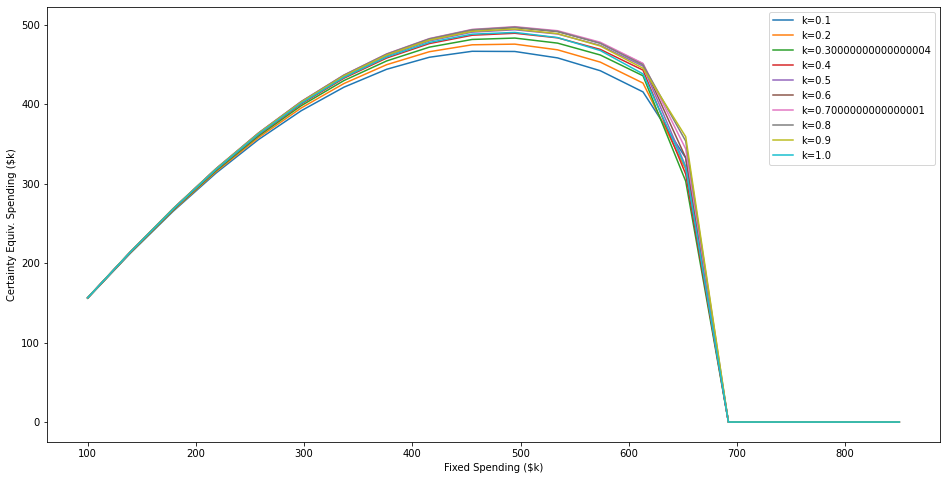

In [ ]:
plot_ces()